In [289]:
import pandas as pd
import json
import os

files = os.listdir("results")

json_files = {}
for file in files:
    if file[-4:] != "json":
        continue
    with open("results/"+file, "r") as f:
        
        df = pd.DataFrame(json.load(f))
        idx = file.split("_")[1][3:]
        df["idx"] = int(idx)
        json_files[file] = df

df = pd.concat(json_files.values(), axis = 0)
df = df[df["idx"] != 5]
df

,tensor_location,criterion_score,layer_name,value_before,value_after,idx
0,"[0, 0, 593]",0.7608,class_token,-0.000760,0.000760,0
1,"[0, 0, 67]",0.7608,class_token,-0.000703,0.000703,0
2,"[0, 0, 690]",0.7608,class_token,-0.000758,0.000758,0
3,"[0, 0, 418]",0.7608,class_token,-0.000655,0.000655,0
4,"[0, 0, 583]",0.7608,class_token,-0.000602,0.000602,0
...,...,...,...,...,...,...
1515,[131],0.7608,heads.head.bias,-0.013511,-0.216172,6
1516,[576],0.7608,heads.head.bias,-0.028518,-0.456286,6
1517,[703],0.7608,heads.head.bias,0.006955,0.000435,6
1518,[361],0.7608,heads.head.bias,0.010427,0.166830,6


In [290]:
majority_class = df[df['idx'] == 0]

# Downsample to 6080
majority_sampled = majority_class.sample(n=6080, random_state=42)

# Combine with the rest
df = pd.concat([
    majority_sampled,
    df[df['idx'] != 0]
])

In [291]:
import numpy as np

df["test_delta"] = 0.7608 - df["criterion_score"]

result = df.groupby("idx").agg(
    criterion_score_mean=("criterion_score", "mean"),
    test_delta_mean=("test_delta", "mean"),
    test_delta_std=("test_delta", "std"),
    critical_error_pct=("criterion_score", lambda x: np.mean(x < 0.1)),
    n_samples=("criterion_score", "count")  # or use any column
)
display(result)

result.to_latex()

,criterion_score_mean,test_delta_mean,test_delta_std,critical_error_pct,n_samples
idx,,,,,
0,0.760769,0.000031,0.000736,0.000000,6080
1,0.173744,0.587056,0.305324,0.743582,6232
3,0.760798,0.000002,0.000180,0.000000,4560
6,0.760128,0.000672,0.020291,0.000822,6080
10,0.760796,0.000004,0.000077,0.000000,6080
15,0.760800,0.000000,0.000000,0.000000,6080
21,0.760800,0.000000,0.000000,0.000000,6080


'\\begin{tabular}{lrrrrr}\n\\toprule\n & criterion_score_mean & test_delta_mean & test_delta_std & critical_error_pct & n_samples \\\\\nidx &  &  &  &  &  \\\\\n\\midrule\n0 & 0.760769 & 0.000031 & 0.000736 & 0.000000 & 6080 \\\\\n1 & 0.173744 & 0.587056 & 0.305324 & 0.743582 & 6232 \\\\\n3 & 0.760798 & 0.000002 & 0.000180 & 0.000000 & 4560 \\\\\n6 & 0.760128 & 0.000672 & 0.020291 & 0.000822 & 6080 \\\\\n10 & 0.760796 & 0.000004 & 0.000077 & 0.000000 & 6080 \\\\\n15 & 0.760800 & 0.000000 & 0.000000 & 0.000000 & 6080 \\\\\n21 & 0.760800 & 0.000000 & 0.000000 & 0.000000 & 6080 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [292]:
df.dtypes

tensor_location     object
criterion_score    float64
layer_name          object
value_before       float64
value_after        float64
idx                  int64
test_delta         float64
dtype: object

In [293]:
df['tensor_location'] = df['tensor_location'].astype(str).astype('|S') # which will by default set the length to the max len it encounters
df['layer_name'] = df['layer_name'].astype('|S') # which will by default set the length to the max len it encounters
df['idx'] = df['idx'].astype('|S') # which will by default set the length to the max len it encounters
df.dtypes

tensor_location       |S16
criterion_score    float64
layer_name            |S62
value_before       float64
value_after        float64
idx                   |S21
test_delta         float64
dtype: object

In [294]:
df = df.sort_values(by = ["layer_name", "idx", "tensor_location", "criterion_score"]).reset_index(drop = True)
df

,tensor_location,criterion_score,layer_name,value_before,value_after,idx,test_delta
0,"b'[0, 0, 135]'",0.7608,b'class_token',-0.000868,0.000868,b'0',0.0000
1,"b'[0, 0, 16]'",0.7608,b'class_token',-0.000807,0.000807,b'0',0.0000
2,"b'[0, 0, 176]'",0.7608,b'class_token',-0.000473,0.000473,b'0',0.0000
3,"b'[0, 0, 227]'",0.7608,b'class_token',-0.002646,0.002646,b'0',0.0000
4,"b'[0, 0, 228]'",0.7608,b'class_token',-0.000710,0.000710,b'0',0.0000
...,...,...,...,...,...,...,...
41187,"b'[81, 527]'",0.7608,b'heads.head.weight',-0.014841,-0.237464,b'6',0.0000
41188,"b'[838, 544]'",0.7610,b'heads.head.weight',0.025741,0.411856,b'6',-0.0002
41189,"b'[868, 656]'",0.7608,b'heads.head.weight',-0.003590,-0.000224,b'6',0.0000
41190,"b'[903, 296]'",0.7608,b'heads.head.weight',-0.028036,-0.448577,b'6',0.0000


<Axes: xlabel='idx', ylabel='criterion_score'>

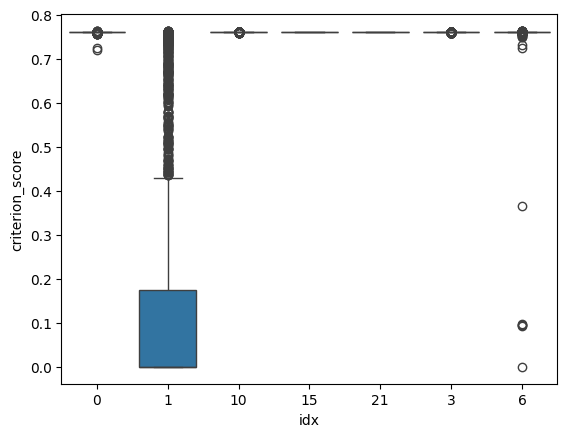

In [295]:
import seaborn as sns

sns.boxplot(data = df, x = "idx", y = "criterion_score")

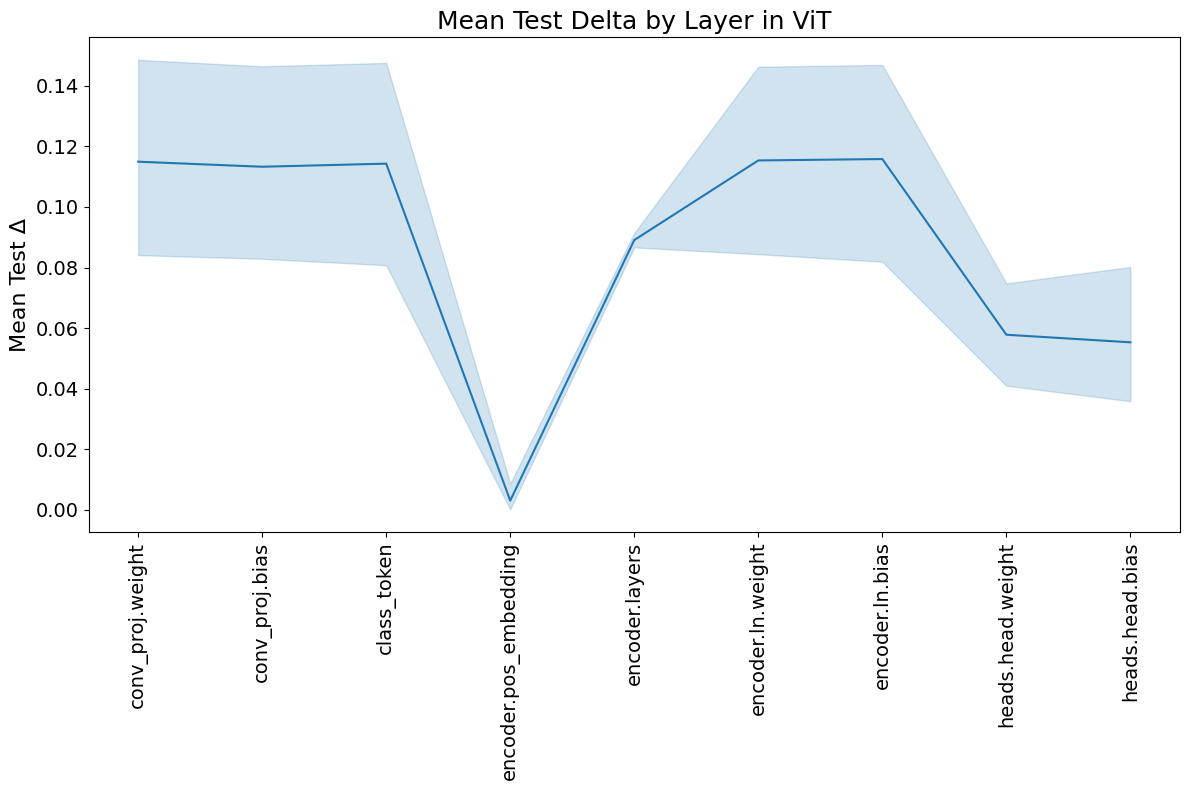

        layer_name_short  mean_test_delta  count  std_test_delta
0       conv_proj.weight         0.114951    271        0.272765
1         conv_proj.bias         0.113286    275        0.271115
2            class_token         0.114303    273        0.271866
3  encoder.pos_embedding         0.003045    273        0.045980
4         encoder.layers         0.089076  39016        0.242015
5      encoder.ln.weight         0.115367    270        0.273066
6        encoder.ln.bias         0.115825    269        0.273591
7      heads.head.weight         0.057817    270        0.137097
8        heads.head.bias         0.055313    275        0.197656


C:\Users\wwden\AppData\Local\Temp\ipykernel_18912\2421923491.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_table = df.groupby("layer_name_short")["test_delta"].agg(


In [296]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def short_name(x):
    if "class_token" in x:
        return "class_token"

    if "encoder.layers" in x:
        return "encoder.layers"

    if len(x.split(".")) > 2:
        return ".".join([x.split(".")[0], x.split(".")[1], x.split(".")[-1]])
    elif len(x.split(".")) == 2:
        return ".".join([x.split(".")[0], x.split(".")[1]])
    else:
        x

# Create short layer names
df["layer_name_short"] = df["layer_name"].astype(str).apply(short_name)

# # Define custom forward pass order (based on ViT-B_32 architecture)
forward_order = [
    "conv_proj.weight",
    "conv_proj.bias",
    "class_token",
    "encoder.pos_embedding",
    "encoder.layers",
    "encoder.ln.weight",
    "encoder.ln.bias",
    "heads.head.weight",
    "heads.head.bias"
]

# Ensure the column is categorical with the correct order
df["layer_name_short"] = pd.Categorical(df["layer_name_short"], categories=forward_order, ordered=True)
df = df.sort_values("layer_name_short")

# Plot
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x="layer_name_short", y="test_delta")
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("", fontsize=16)
plt.ylabel("Mean Test Δ", fontsize=16)
plt.title("Mean Test Delta by Layer in ViT", fontsize=18)
plt.tight_layout()
plt.savefig("ViT_layer_test_delta.pdf")
plt.show()



agg_table = df.groupby("layer_name_short")["test_delta"].agg(
    mean_test_delta="mean",
    count="size",
    std_test_delta="std"
).reset_index()

print(agg_table)


In [297]:
np.sort(df["layer_name"].unique())

array([b'class_token', b'conv_proj.bias', b'conv_proj.weight',
       b'encoder.layers.encoder_layer_0.ln_1.bias',
       b'encoder.layers.encoder_layer_0.ln_1.weight',
       b'encoder.layers.encoder_layer_0.ln_2.bias',
       b'encoder.layers.encoder_layer_0.ln_2.weight',
       b'encoder.layers.encoder_layer_0.mlp.0.bias',
       b'encoder.layers.encoder_layer_0.mlp.0.weight',
       b'encoder.layers.encoder_layer_0.mlp.3.bias',
       b'encoder.layers.encoder_layer_0.mlp.3.weight',
       b'encoder.layers.encoder_layer_0.self_attention.in_proj_bias',
       b'encoder.layers.encoder_layer_0.self_attention.in_proj_weight',
       b'encoder.layers.encoder_layer_0.self_attention.out_proj.bias',
       b'encoder.layers.encoder_layer_0.self_attention.out_proj.weight',
       b'encoder.layers.encoder_layer_1.ln_1.bias',
       b'encoder.layers.encoder_layer_1.ln_1.weight',
       b'encoder.layers.encoder_layer_1.ln_2.bias',
       b'encoder.layers.encoder_layer_1.ln_2.weight',
       b'en

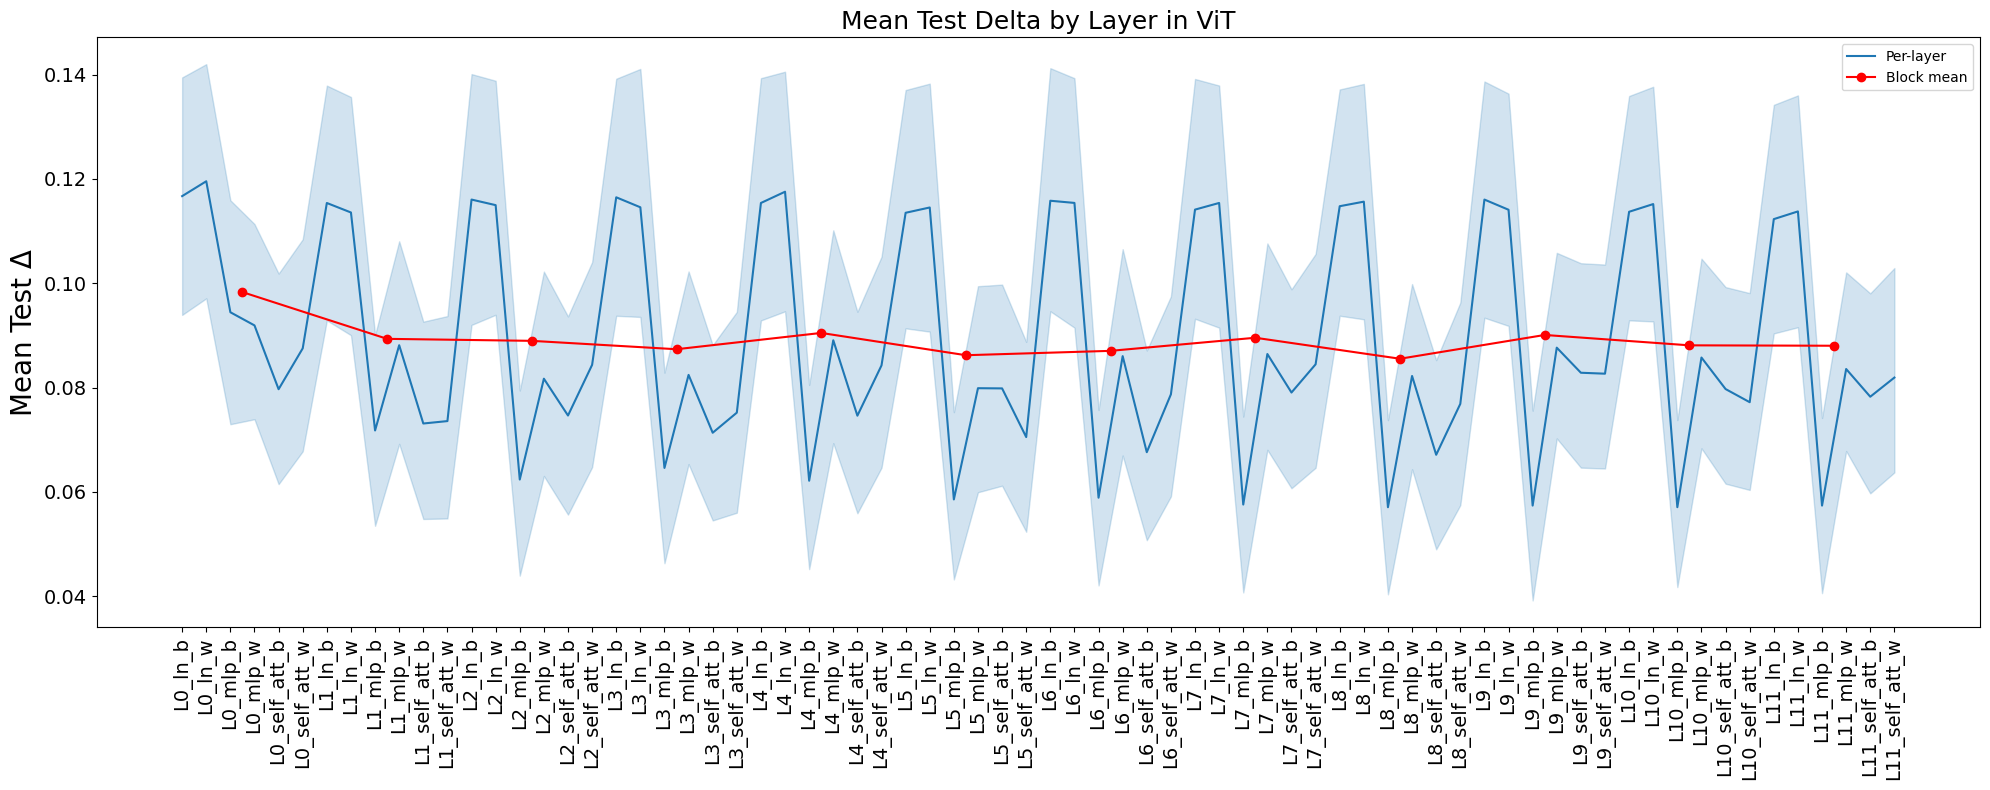

   layer_name_short  mean_test_delta  count  std_test_delta
0           L0_ln_b         0.116694    534        0.274175
1           L0_ln_w         0.119544    554        0.275346
2          L0_mlp_b         0.094435    531        0.250908
3          L0_mlp_w         0.091916    556        0.234376
4     L0_self_att_b         0.079683    549        0.229484
5     L0_self_att_w         0.087518    536        0.239770
6           L1_ln_b         0.115381    540        0.272926
7           L1_ln_w         0.113558    549        0.271042
8          L1_mlp_b         0.071773    540        0.222402
9          L1_mlp_w         0.088117    553        0.236824
10    L1_self_att_b         0.073111    542        0.223914
11    L1_self_att_w         0.073574    533        0.223514
12          L2_ln_b         0.116036    537        0.273548
13          L2_ln_w         0.114968    542        0.272514
14         L2_mlp_b         0.062375    536        0.208760
15         L2_mlp_w         0.081700    

C:\Users\wwden\AppData\Local\Temp\ipykernel_18912\2904822115.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_table = df_filtered.groupby("layer_name_short")["test_delta"].agg(


In [298]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

not_include = [
    "conv_proj.weight",
    "conv_proj.bias",
    "class_token",
    "encoder.pos_embedding",
    "heads.head.weight",
    "heads.head.bias",
    "encoder.ln.weight",
    "encoder.ln.bias"
]

# Decode layer_name from bytes to str if needed
df["layer_name_str"] = df["layer_name"].apply(lambda x: x.decode() if isinstance(x, bytes) else str(x))

# Filter out excluded layers
df_filtered = df[~df["layer_name_str"].isin(not_include)].copy()

# Shorten layer names for plot
def shorten_name(name):
    layer_num = re.search(r"encoder_layer_(\d+)", name)
    layer_num = f"L{layer_num.group(1)}" if layer_num else "Global"

    if "self_attention" in name:
        submodule = "self_att"
    elif ".mlp." in name:
        submodule = "mlp"
    elif ".ln_" in name:
        submodule = "ln"
    elif "pos_embedding" in name:
        submodule = "pos_emb"
    elif "heads.head" in name:
        submodule = "head"
    else:
        submodule = "other"

    if "weight" in name:
        param = "w"
    elif "bias" in name:
        param = "b"
    else:
        param = "p"

    return f"{layer_num}_{submodule}_{param}"

df_filtered["layer_name_short"] = df_filtered["layer_name_str"].apply(shorten_name)

# Extract block number
def extract_layer_num(name):
    match = re.search(r"encoder_layer_(\d+)", name)
    return int(match.group(1)) if match else -1

df_filtered["layer_num"] = df_filtered["layer_name_str"].apply(extract_layer_num)

# Ordering by block and submodule
order = (
    df_filtered[["layer_name_short", "layer_num"]]
    .drop_duplicates()
    .sort_values(by=["layer_num", "layer_name_short"])
    ["layer_name_short"]
    .tolist()
)

df_filtered["layer_name_short"] = pd.Categorical(df_filtered["layer_name_short"], categories=order, ordered=True)

# Compute block means
block_mean = df_filtered.groupby("layer_num")["test_delta"].mean().reset_index()

# Compute x position (average index of the layers in the block)
block_mean["x"] = block_mean["layer_num"].apply(
    lambda x: sum([i for i, l in enumerate(order) if f"L{x}_" in l]) / sum([1 for l in order if f"L{x}_" in l])
)

# Plot
plt.figure(figsize=(20, 8))
sns.lineplot(data=df_filtered, x="layer_name_short", y="test_delta", label="Per-layer")
plt.plot(block_mean["x"], block_mean["test_delta"], color='red', marker='o', label="Block mean")

plt.xticks(ticks=range(len(order)), labels=order, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("", fontsize=16)
plt.ylabel("Mean Test Δ", fontsize=20)
plt.title("Mean Test Delta by Layer in ViT", fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig("ViT_layer_test_delta_encoder.pdf")
plt.show()

# Aggregate statistics
agg_table = df_filtered.groupby("layer_name_short")["test_delta"].agg(
    mean_test_delta="mean",
    count="size",
    std_test_delta="std"
).reset_index()

print(agg_table.head(20))


In [308]:
import numpy as np

# Extract submodule from 'layer_name_short'
df_filtered["submodule"] = df_filtered["layer_name_short"].apply(lambda x: "_".join(x.split('_')[1:]))

# Group by 'idx' and 'submodule', then aggregate
agg_block_part = df_filtered.groupby(["submodule"]).agg(
    criterion_score_mean=("criterion_score", "mean"),
    test_delta_mean=("test_delta", "mean"),
    test_delta_std=("test_delta", "std"),
    critical_error_pct=("criterion_score", lambda x: np.mean(x < 0.1)),
    n_samples=("criterion_score", "count")
).reset_index()

print(agg_block_part)

agg_block_part.to_latex()


    submodule  criterion_score_mean  test_delta_mean  test_delta_std  \
0        ln_b              0.645801         0.114999        0.272311   
1        ln_w              0.645458         0.115342        0.272502   
2       mlp_b              0.697596         0.063204        0.209836   
3       mlp_w              0.675392         0.085408        0.226577   
4  self_att_b              0.685159         0.075641        0.226929   
5  self_att_w              0.681044         0.079756        0.232012   

   critical_error_pct  n_samples  
0            0.151338       6502  
1            0.151757       6517  
2            0.083179       6492  
3            0.089442       6507  
4            0.098940       6509  
5            0.103868       6489  


'\\begin{tabular}{llrrrrr}\n\\toprule\n & submodule & criterion_score_mean & test_delta_mean & test_delta_std & critical_error_pct & n_samples \\\\\n\\midrule\n0 & ln_b & 0.645801 & 0.114999 & 0.272311 & 0.151338 & 6502 \\\\\n1 & ln_w & 0.645458 & 0.115342 & 0.272502 & 0.151757 & 6517 \\\\\n2 & mlp_b & 0.697596 & 0.063204 & 0.209836 & 0.083179 & 6492 \\\\\n3 & mlp_w & 0.675392 & 0.085408 & 0.226577 & 0.089442 & 6507 \\\\\n4 & self_att_b & 0.685159 & 0.075641 & 0.226929 & 0.098940 & 6509 \\\\\n5 & self_att_w & 0.681044 & 0.079756 & 0.232012 & 0.103868 & 6489 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [307]:
import torchvision.models as models

model = models.vit_b_32(pretrained=True)

# Access key components of the ViT model (from torchvision source code):
# - conv_proj (patch embedding conv)
# - encoder (transformer encoder)
# - class_token (parameter)
# - encoder.pos_embedding (positional embedding)

print("Forward pass order components:\n")

print("conv_proj:")
print(model.conv_proj)  # conv patch embedding

print("\nclass_token:")
print(model.class_token.shape)

print("\npos_embedding:")
print(model.encoder.pos_embedding.shape)

print("\nEncoder blocks:")
for i, block in enumerate(model.encoder.layers):
    print(f"  Encoder block {i}: {block}")

print("\nHeads / output layers:")
print(model.heads)


c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Repositories\seu-injection-framework\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Forward pass order components:

conv_proj:
Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))

class_token:
torch.Size([1, 1, 768])

pos_embedding:
torch.Size([1, 50, 768])

Encoder blocks:
  Encoder block 0: EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (mlp): MLPBlock(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)
  Encoder block 1: EncoderBlock(
  (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, 

In [301]:
model.encoder.layers[0].ln_1.weight.shape  # or .bias


torch.Size([768])

In [302]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [303]:
df["idx"].value_counts()

C:\Users\wwden\AppData\Local\Temp\ipykernel_18912\2608930675.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  df["idx"].value_counts()


idx
b'1'     6232
b'10'    6080
b'15'    6080
b'0'     6080
b'6'     6080
b'21'    6080
b'3'     4560
Name: count, dtype: int64